In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
import os
import package_DBR
import PACKAGE_LAB

#from importlib import reload
#package_DBR = reload(package_DBR)
#PACKAGE_LAB = reload(PACKAGE_LAB)

from package_DBR import *
from PACKAGE_LAB import *

# help stability margin

In [2]:
help(stability_margin)

Help on function stability_margin in module PACKAGE_LAB:

stability_margin(process_obj, controller_obj, omega_freq)
    Calculate stability margins using the Bode method.
    
    :process_obj: Process object.
    :controller_obj: Controller object.
    :omega_freq: Frequency vector (rad/s).
    
    Returns stability margins.



# stability margin

### initialize values

In [3]:
# Parameters Step response MV
Kp = 0.22940157900053862
T1p = 235.05979493875853  
T2p =  4.990264278507082
thetap =  50.462409314789745

# Parameters Step response DV
Kd = 0.407
T1d =  150.244  
T2d =  2.7537
thetad = 6

Kc, Ti, Td = IMC_TUNING(Kp,T1p,T2p,thetap,0.6,'SOPDT')

# Process object
P = Process({})
#P.parameters['kp'] = kp
P.parameters['kp'] = Kp
P.parameters['Tlead1'] = 0
P.parameters['Tlag1'] = T1p
P.parameters['Tlag2'] = T2p
P.parameters['theta'] = thetap
P.parameters['nInt'] = 0

C = Controller({})
C.parameters['Kc'] = Kc
C.parameters['Ti'] = Ti
C.parameters['Td'] = Td
C.parameters['alpha'] = 0.4

### Calculate and plot data

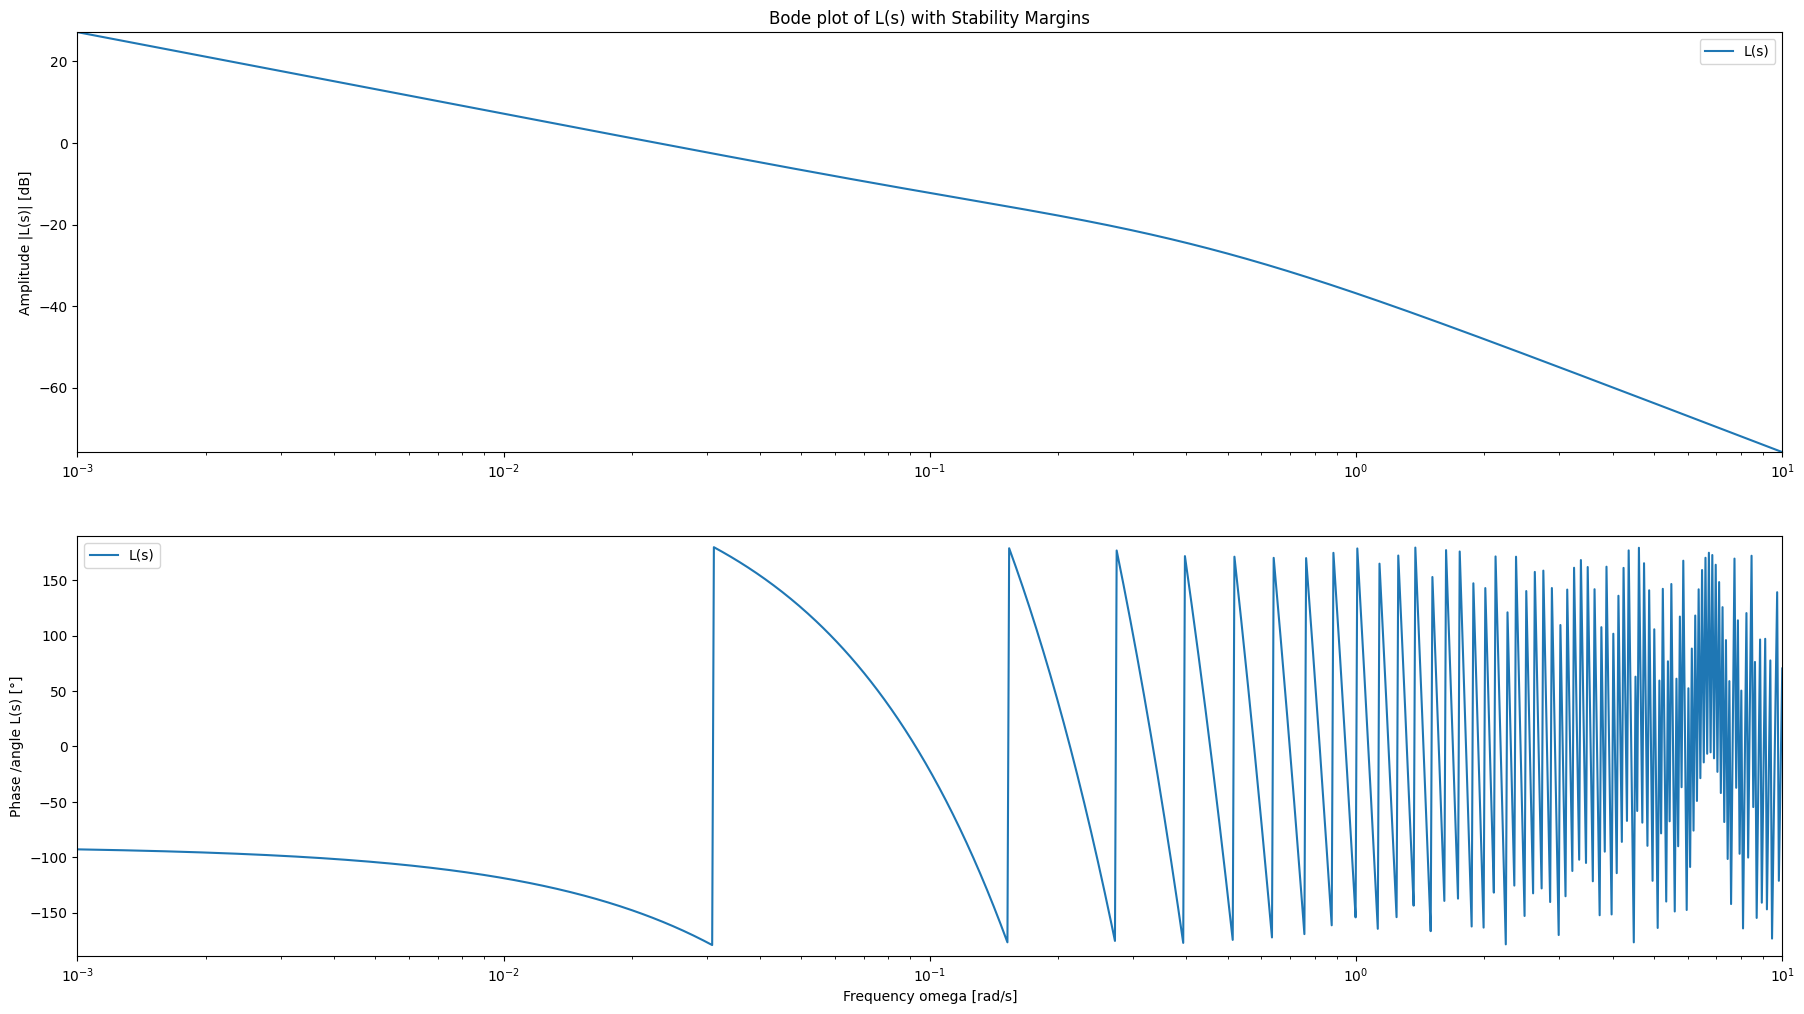

In [4]:

# Convert single value to an array
omega_freq = np.logspace(-3, 1, 1000)  # Utilisez une plage logarithmique de fréquences
x_gain_margin, y_gain_margin, crossover_freq, phase_margin, x_phase_margin, y_phase_margin, unity_gain_freq, gain_margin, gain_values, phase_values = stability_margin(P, C, omega_freq)
plot_bode_diagrams(P, C, omega_freq, gain_values, phase_values, x_gain_margin, y_gain_margin, crossover_freq, phase_margin, x_phase_margin, y_phase_margin, unity_gain_freq, gain_margin)

# help IMC TUNING

In [5]:
help(IMC_TUNING)

Help on function IMC_TUNING in module PACKAGE_LAB:

IMC_TUNING(Kp, T1, T2, theta, gamma, method='FOPDT')
    The function IMC tuning returns the IMC controller parameters Kc, Ti and Td for a FOPDT or SOPDT process model.
    
    :Kp: process gain
    :T1: first (or main) lag time constant [s]
    :T2: second lag time constant [s]
    :theta: delay [s]
    :gamma: IMC tuning parameter
    :method: process model (optional: default value is 'FOPDT')



# test imc tuning

In [6]:
# Parameters Step response MV
Kp = 0.22940157900053862
T1p = 235.05979493875853
T2p =  4.990264278507082
thetap =  50.462409314789745
gamma = 0.6

Kc, Ti, Td = IMC_TUNING(Kp,T1p,T2p,thetap,gamma,'SOPDT')
print(Kc, Ti, Td)

5.464375339910806 240.0500592172656 4.886524510016525


# help LL_RT

In [7]:
help(LL_RT)

Help on function LL_RT in module PACKAGE_LAB:

LL_RT(MV, Kp, TLead, TLag, Ts, MVFF, PVInit=0, method='EBD')
    The function "LL_RT" needs to be included in a "for or while loop".
    
    :MV: input vector
    :Kp: process gain
    :T1: lead time constant [s]
    :TLead: lead time constant [s]
    :TLag: lag time constant [s] 
    :Ts: sampling period [s]
    :PV: output vector
    :PVInit: (optional: default value is 0)
    :method: discretisation method (optional: default value is 'EBD')
        EBD: Euler Backward difference
        EFD: Euler Forward difference
        TRAP: Trapezoïdal method
    
    The function "LL_RT" appends a value to the output vector "PV".
    The appended value is obtained from a recurrent equation that depends on the discretisation method.



# Single plot of LL_RT

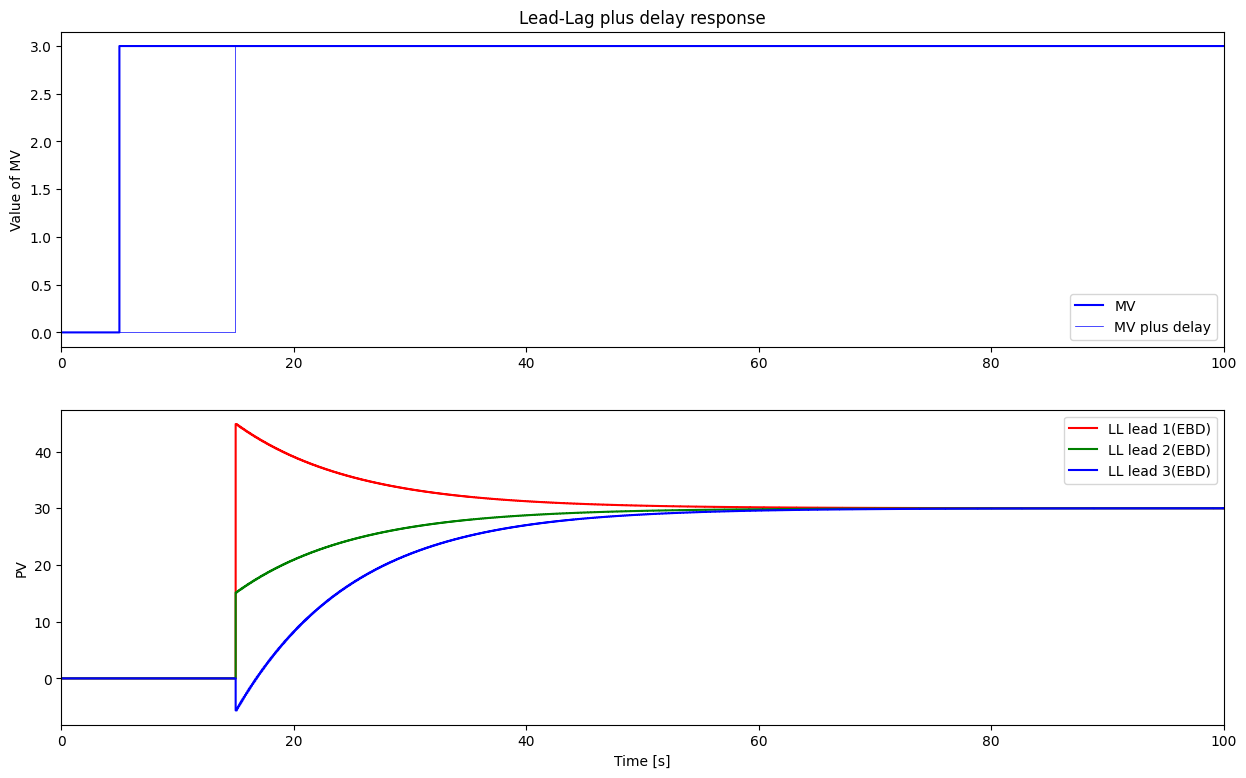

In [8]:
TSim = 100
Ts = 0.1
N = int(TSim / Ts) + 1
theta = 5
Kp = 10

Tlead_1 = 15
Tlead_2 = 5
Tlead_3 = -2
Tlag = 10
theta = 10

global MVFF
MVPath = {0: 0, 5:3, TSim: 3}
# Initialize lists
t = []
MV = []
PV = []
MVDelay = []
PV_EBD_1 = []
PV_EBD_LEAD1 = []
PV_EBD_LEAD2 = []
PV_EBD_LEAD3 = []

for i in range(0, N):
    t.append(i * Ts)
    SelectPath_RT(MVPath, t, MV)
    Delay_RT(MV, theta, Ts, MVDelay)
    LL_RT(MVDelay, Kp, Tlead_1, Tlag, Ts, PV_EBD_LEAD1)
    LL_RT(MVDelay, Kp, Tlead_2, Tlag, Ts, PV_EBD_LEAD2)
    LL_RT(MVDelay, Kp, Tlead_3, Tlag, Ts, PV_EBD_LEAD3)

plt.figure(figsize=(15, 9))

plt.subplot(2, 1, 1)
plt.step(t, MV, 'b-', label='MV', where='post')
plt.step(t, MVDelay, 'b-', linewidth=0.5, label='MV plus delay', where='post')
plt.ylabel('Value of MV')
plt.title('Lead-Lag plus delay response')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(2, 1, 2)
plt.step(t, PV_EBD_LEAD1, 'r-', label='LL lead 1(EBD)', where='post')
plt.step(t, PV_EBD_LEAD2, 'g-', label='LL lead 2(EBD)', where='post')
plt.step(t, PV_EBD_LEAD3, 'b-', label='LL lead 3(EBD)', where='post')

plt.ylabel('PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.show()

# interactive plot of LL_RT

In [9]:
import ipywidgets as widgets
from IPython.display import display


# Function to generate graphs based on parameters
def generate_graphs(Tlead_1, Tlead_2, Tlead_3, Tlag, theta):
    TSim = 100
    Ts = 0.1
    N = int(TSim / Ts) + 1
    theta = 5
    Kp = 10
    global MVFF
    MVPath = {0: 0, 5:3, TSim: 3}
   # Initialize lists
    t = []
    MV = []
    PV = []
    MVDelay = []
    PV_EBD_1 = []
    PV_EBD_LEAD1 = []
    PV_EBD_LEAD2 = []
    PV_EBD_LEAD3 = []

    for i in range(0, N):
        t.append(i * Ts)
        SelectPath_RT(MVPath, t, MV)
        Delay_RT(MV, theta, Ts, MVDelay)
        LL_RT(MVDelay, Kp, Tlead_1, Tlag, Ts, PV_EBD_LEAD1)
        LL_RT(MVDelay, Kp, Tlead_2, Tlag, Ts, PV_EBD_LEAD2)
        LL_RT(MVDelay, Kp, Tlead_3, Tlag, Ts, PV_EBD_LEAD3)

    plt.figure(figsize=(15, 9))

    plt.subplot(2, 1, 1)
    plt.step(t, MV, 'b-', label='MV', where='post')
    plt.step(t, MVDelay, 'b-', linewidth=0.5, label='MV plus delay', where='post')
    plt.ylabel('Value of MV')
    plt.title('Lead-Lag plus delay response')
    plt.legend(loc='best')
    plt.xlim([0, TSim])

    plt.subplot(2, 1, 2)
    plt.step(t, PV_EBD_LEAD1, 'r-', label='LL lead 1(EBD)', where='post')
    plt.step(t, PV_EBD_LEAD2, 'g-', label='LL lead 2(EBD)', where='post')
    plt.step(t, PV_EBD_LEAD3, 'b-', label='LL lead 3(EBD)', where='post')

    plt.ylabel('PV')
    plt.xlabel('Time [s]')
    plt.legend(loc='best')
    plt.xlim([0, TSim])

    plt.show()

# Create widgets for parameter adjustment
Tlead_1_widget = widgets.FloatSlider(value=15, min=-100, max=100, step=0.1, description='Tlead_1:')
Tlead_2_widget = widgets.FloatSlider(value=5, min=-100, max=100, step=0.1, description='Tlead_2:')
Tlead_3_widget = widgets.FloatSlider(value=-2, min=-100, max=100, step=0.1, description='Tlead_3:')
Tlag_widget = widgets.FloatSlider(value=10, min=-100, max=100, step=0.1, description='Tlag:')
theta_widget = widgets.FloatSlider(value=10, min=-100, max=100, step=0.1, description='Theta:')

# Create an interactive widget
widgets.interactive(generate_graphs, Tlead_1=Tlead_1_widget, Tlead_2=Tlead_2_widget, Tlead_3=Tlead_3_widget, Tlag=Tlag_widget, theta=theta_widget)


interactive(children=(FloatSlider(value=15.0, description='Tlead_1:', min=-100.0), FloatSlider(value=5.0, desc…

In [10]:
help(PID_RT)

Help on function PID_RT in module PACKAGE_LAB:

PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF=False, PVInit=0, method='EBD-EBD')
    Applies Proportional Integral Derivative (PID) control to regulate a process variable.
    
    :param SP: Setpoint vector
    :param PV: Process variable vector
    :param Man: Manual mode vector
    :param MVMan: Manual mode input vector
    :param MVFF: Feedforward input vector
    :param Kc: Proportional gain
    :param Ti: Integral time constant
    :param Td: Derivative time constant
    :param alpha: Derivative filter coefficient
    :param Ts: Sampling period
    :param MVMin: Minimum manipulated variable (MV) value
    :param MVMax: Maximum MV value
    :param MV: MV vector
    :param MVP: Proportional action vector
    :param MVI: Integral action vector
    :param MVD: Derivative action vector
    :param E: Error vector
    :param ManFF: Boolean indicating whether feedforward is activated in ma

# Initialise constants

In [11]:
# Define simulation parameters
TSim = 500
Ts = 0.5
N = int(TSim / Ts) + 1

global MV

# Define MV & SP path
SPPath = {0: 50, 5: 60,100:90,200:40,300:45, TSim: 60} 
PVpath = {0: 50, TSim: 50}   
ManPath = {0: False,340: True, TSim: False} 
MVManPath = {0: 0,340:40,400:0, TSim: 0}
MVFFPath = {0: 0, TSim: 0}


Kc=3
TD=50
alpha=0.9

# Set maximum and minimum MV values
MVmin = 0
MVmax = 100

TI = TD/0.25

# Initialize lists
TLead = 1
TLag = 1
SP = []
PV = []
Man = []
MVMan = []
MVFF = []
MV = []
MVp = []
MVi = []
MVd = []
E = []
t=[]
MVDelay = []


# Calculate graphs

In [12]:
for i in range(0, N):
    t.append(i * Ts)
    SelectPath_RT(SPPath, t, SP)
    SelectPath_RT(PVpath, t, PV)
    SelectPath_RT(ManPath, t, Man)
    SelectPath_RT(MVManPath, t, MVMan)
    SelectPath_RT(MVFFPath, t, MVFF)
 # Generate time vector and simulate MV, MVp, MVi, MVd, and E
for i in range(0, N):
    #Delay_RT(MV, theta, Ts, MVDelay)
    #LL_RT(MVDelay, Kp, Tlead_1, Tlag, Ts, MVFF)
    PID_RT(SP[0:i+1], PV[0:i+1], Man[0:i+1], MVMan[0:i+1], MVFF[0:i+1], Kc, TI, TD, alpha, Ts, MVmin, MVmax, MV, MVp, MVi, MVd, E)




# Display

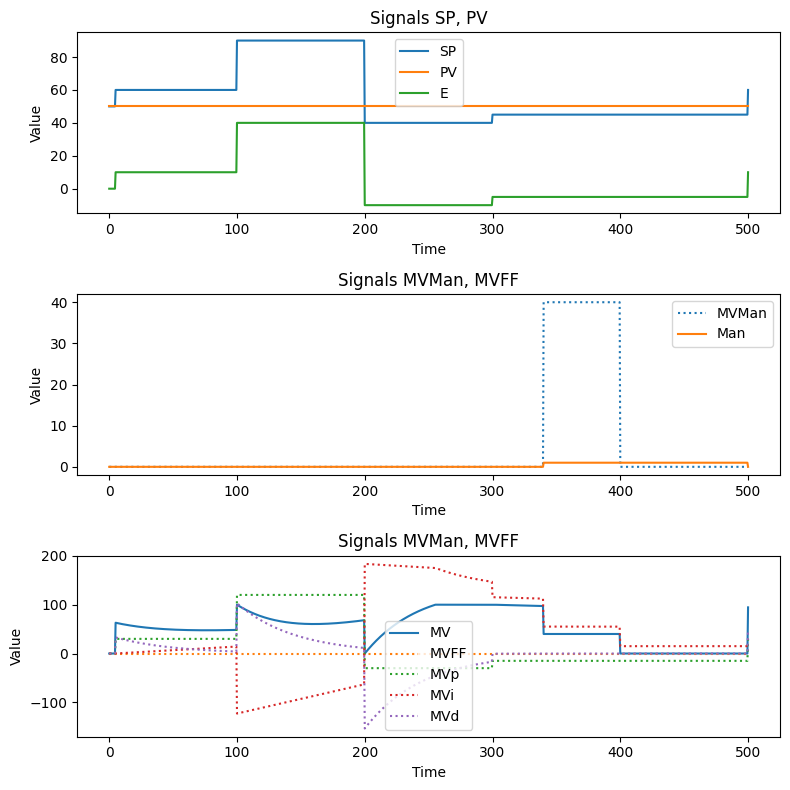

In [13]:

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# Plotting for the first subplot
axs[0].plot(t, SP, label='SP')
axs[0].plot(t, PV, label='PV')
axs[0].plot(t, E, label='E')
axs[0].set_title('Signals SP, PV')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Value')
axs[0].legend()

# Plotting for the second subplot with MVMan and MVFF in dotted lines
axs[1].plot(t, MVMan, linestyle=':', label='MVMan')  # MVMan plotted with dotted line
axs[1].plot(t, Man, label='Man')
axs[1].set_title('Signals MVMan, MVFF')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Value')
axs[1].legend()

# Plotting for the third subplot with all signals
axs[2].plot(t, MV, label='MV')  # MV plotted with dotted line
axs[2].plot(t, MVFF, linestyle=':', label='MVFF')  # MVFF plotted with dotted line
axs[2].plot(t, MVp, linestyle=':', label='MVp')
axs[2].plot(t, MVi, linestyle=':', label='MVi')
axs[2].plot(t, MVd, linestyle=':', label='MVd')
axs[2].set_title('Signals MVMan, MVFF')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Value')
axs[2].legend()

plt.tight_layout()
plt.show()